In [1]:
using Pkg; Pkg.instantiate(); Pkg.precompile()

Precompiling project...


In [2]:
using Random; Random.seed!(2020);

# What is the average grain size?

We have a Micro-CT image of a rock sample such as the *Ketton* image provided by the [PERM Research Group at Imperial College London](http://www.imperial.ac.uk/earth-science/research/research-groups/perm/research/pore-scale-modelling/micro-ct-images-and-networks), and wish to estimate the average grain size within this sample. The average grain size (and corresponding porosity) can be an important parameter for subsurface characterization, but assigning a single value for the sample objectively is not always trivial.

<img src="https://raw.githubusercontent.com/JuliaEarth/GeoStatsImages.jl/master/src/data/Ketton.png" width="30%">
<div style="text-align: center"> <b>Image credit:</b> <i>PERM at Imperial College London</i> </div>

**Problem statement**:

Estimate the average grain size (e.g. average spheroid radius $\bar{r}$) in the rock sample.

*Can we do any better than visual estimation?*

In [3]:
using GeoStats
using GeoStatsImages
using Plots; gr(c=:cividis, ms=2)

𝒦 = geostatsimage("Ketton")

256×256×256 RegularGridData{Float64,3}
  origin:  (0.0, 0.0, 0.0)
  spacing: (1.0, 1.0, 1.0)
  variables
    └─grain (Float64)

## Two-point statistics

We will solve this problem by estimating the probability of two locations $\newcommand{\u}{\mathbf{u}}\newcommand{\v}{\mathbf{v}}\newcommand{\R}{\mathbb{R}} \u,\v\in\R^3$ to be on a grain, and by understanding how this probability changes as the distance $h=||\u-\v||$ between these locations is made larger.

Consider two Bernoulli random variables $Z_\u$ and $Z_\v$ that indicate *grain* with probability $p$ and *non-grain* with probability $1-p$ at locations $\u$ and $\v$, respectively. The variogram between these locations is defined as:

$$
\newcommand{\E}{\mathbb{E}}
\gamma(h) = \frac{1}{2} \E\left[(Z_\u - Z_\v)^2\right] = \frac{1}{2}\left(\E\left[Z_\u^2\right] + \E\left[Z_\v^2\right] - 2\E\left[Z_\u Z_\v\right]\right)
$$

We can derive the expectations:

- $\E\left[Z_\u^2\right] = \E[Z_\u Z_\u] = Pr(Z_\u=1, Z_\u=1) = Pr(Z_\u=1)$
- $\E[Z_\u Z_\v] = Pr(Z_\u=1, Z_\v=1) = Pr(Z_\u=1)Pr(Z_\v=1 | Z_\u=1)$
- $\E\left[Z_\v^2\right] = Pr(Z_\v=1)$ (exactly like above)

and use the fact that $Pr(Z_\u=1) = Pr(Z_\v=1) = p$ to rewrite the variogram as:

$$
\gamma(h) = p\cdot\big(1 - Pr(Z_\v=1 | Z_\u=1)\big) = p\cdot Pr(Z_\v=0|Z_\u=1)
$$

or alternatively:

$$
Pr(Z_\v=0 | Z_\u=1) = \frac{\gamma(h)}{p}
$$

This last equation shows that we can calculate the probability that a location $\v$ is *non-grain* given that a location $\u$ is *grain* (left-hand-side) provided that we can efficiently estimate the variogram $\gamma(h)$ and the marginal probability $p$ from spatial data (right-hand-side).

### Partition variograms

We devised efficient parallel algorithms for variogram estimation over general spatial partitions. For those interested in more details, we recommend reading our paper [Hoffimann & Zadrozny 2019](https://www.sciencedirect.com/science/article/pii/S0098300419302936). Here, we consider 1M samples from the Ketton rock for demonstration purposes:

In [4]:
𝒮 = sample(𝒦, 1_000_000, replace=false)

1000000 DataView{Float64,3}
  variables
    └─grain (Float64)

Given that grains can sometimes be ellipsoids due to compaction and other physical processes, we would like to characterize the "average ellipsoid shape" of these grains or, equivalently, the major and minor axis on different planes of variation.

For example, we can consider planes that are normal to the vertical direction in order to estimate the average horizontal radius of the grains:

In [5]:
𝒫 = partition(𝒮, PlanePartitioner((0.,0.,1.)))

plot(𝒫[1])
plot!(𝒫[2])
plot!(𝒫[3])

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/juliohm/.julia/packages/Plots/u8HRI/src/backends/gr.jl:491


We make sure that we have started Julia with multiple threads, and let each thread estimate the variogram of a subset of planes:

In [6]:
γₑ = @time EmpiricalVariogram(𝒫, :grain)

 13.560439 seconds (1.42 G allocations: 25.868 GiB, 27.93% gc time)


EmpiricalVariogram
  abscissa: (0.9015611460128481, 35.16088469450108)
  ordinate: (0.01864478966366427, 0.1130675764467619)
  N° pairs: 107545403


These two steps can be performed together using a `PlanarVariogram`, where the first argument is the normal direction to the planes of interest:

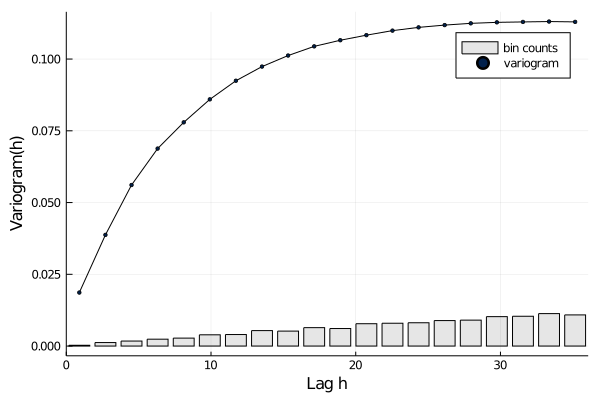

In [7]:
γₑ = PlanarVariogram((0.,0.,1.), 𝒮, :grain)

plot(γₑ)

In order to evaluate the variogram at any distance (or lag) $h$, we fit a theoretical variogram model:

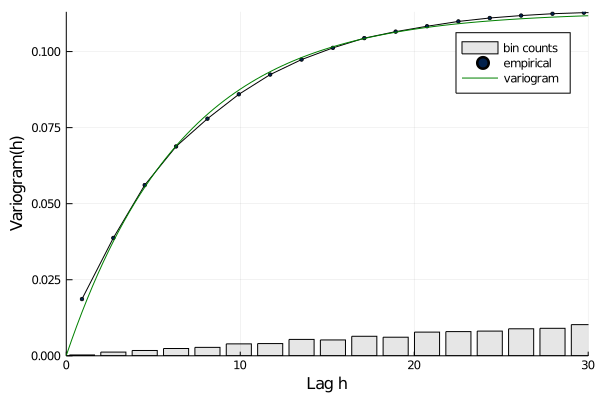

In [8]:
γₜ = fit(ExponentialVariogram, γₑ)

plot(γₑ, label="empirical")
plot!(γₜ, c=:green, maxlag=30.)

We estimate the marginal probability $p$ using the proportion of *grain* in the rock sample:

In [9]:
p = mean(𝒮[:grain])

0.872949

### Probability versus distance

We can divide our variogram $\gamma$ by the marginal probability $p$ to obtain the probability $Pr(Z_\v=0|Z_\u=1)$ as a function of the distance $h = ||\u-\v||$.

As shown below, the probability levels out at some positive distance (known as the variogram range), after which the chance of encountering a *non-grain* at location $\v$ given a *grain* at location $\u$ is simply the marginal probability of *non-grain* $1-p$ (the proportion of *non-grain* in the rock).

The distance at which the probability levels out is the average grain radius:

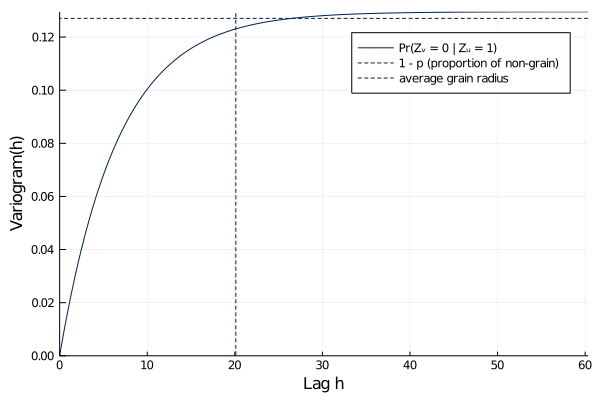

In [10]:
plot((1/p) * γₜ, label="Pr(Zᵥ = 0 | Zᵤ = 1)")
hline!([1-p], ls=:dash, label="1 - p (proportion of non-grain)")
vline!([range(γₜ)], ls=:dash, label="average grain radius")

### Average grain size

We can create a function to compute the average grain radius for any plane of variation given a normal direction:

In [11]:
function radius(normal)
    γₑ = PlanarVariogram(normal, 𝒮, :grain)
    γₜ = fit(ExponentialVariogram, γₑ)
    p = mean(𝒮[:grain])
    range((1/p) * γₜ)
end

for normal in [(1.,0.,0.), (0.,1.,0.), (0.,0.,1.)]
    println(normal, " → ", radius(normal))
end

(1.0, 0.0, 0.0) → 18.378153943606204
(0.0, 1.0, 0.0) → 18.082732918868874
(0.0, 0.0, 1.0) → 20.115404723053793


We notice that the average radius is smaller on vertical planes (anisotropic media) compared to horizontal planes. We can estimate the average radius for all angles within vertical planes using a `EmpiricalVarioplane`:

In [12]:
γₚ = @time EmpiricalVarioplane(𝒮, :grain, maxlag=30., normal=(1.,0.,0.))

 81.405196 seconds (1.90 G allocations: 80.216 GiB, 15.29% gc time)


EmpiricalVarioplane
  N° pairs
  └─0.00° → 1678838
  └─3.67° → 1360386
  └─7.35° → 1371278
  └─11.02° → 1384572
  └─14.69° → 1376467
  ⋮
  └─165.31° → 1374724
  └─168.98° → 1383435
  └─172.65° → 1371025
  └─176.33° → 1362834
  └─180.00° → 1678838

The following plot depicts the "average grain shape" on vertical sections of the rock:

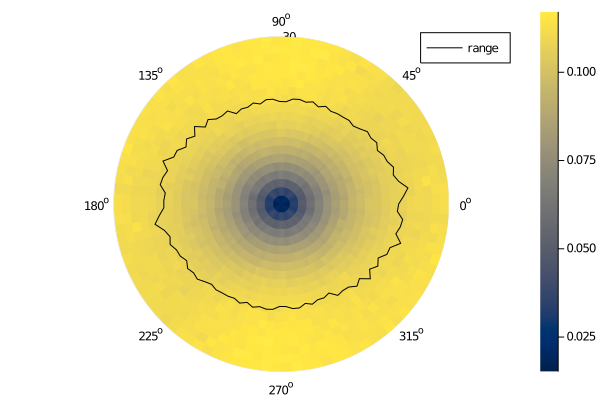

┌ Warning: Right now only the maximum value of y (r) is taken into account.
└ @ Plots /home/juliohm/.julia/packages/Plots/u8HRI/src/backends/gr.jl:1739


In [13]:
plot(γₚ, model=ExponentialVariogram)

## Remarks

- Variograms can be useful to efficiently estimate two-point spatial probabilities.
- We've shown that the variogram range represents the "average grain radius".
- GeoStats.jl provides variogram estimators that can handle more than 1M points.
- For more details, please check:
  - *Hoffimann & Zadrozny. 2019.* [Efficient variography with partition variograms](https://www.sciencedirect.com/science/article/pii/S0098300419302936)